In [1]:
from HARK.frame import Frame, FrameAgentType, FrameModel, BackwardFrameReference, ForwardFrameReference

import matplotlib.pyplot as plt
import networkx as nx

from HARK.distribution import combine_indep_dstns, add_discrete_outcome_constant_mean
from HARK.distribution import (
    IndexDistribution,
    Lognormal,
    MeanOneLogNormal,
    Bernoulli  # Random draws for simulating agents
)

TO DO:

Refactor to separate model from simulator (AgentType)

- [x] Separate FrameModel from FrameAgentType - AgentType has cycles parameter. FrameModel need not have it.
- [ ] Define Repeater transformation -- transforms FrameModel to be either explicitly infinite or to become finite cycled. Can take age-varying parameters here (and only here).
- [x] FrameAgentType consumes a FrameModel, and runs simulations in HARK way

Solver as something that consumes and works with a FrameModel

- [ ] Data structure for the solution of a model? -- A policy. (Look at Bellman library?)
- [ ] Extract the key sequence of variables along which to pass value
- [ ] Value-passing -- inverse function 
- [ ] Value-passing -- Inverse expected value -- for chance transitions
- [ ] Policy updating --
- [ ] Value backup

Solvers for repeated FrameModels

- [ ] Finite solver as composition of these tools
- [ ] Infinite solver through use of tools to convergence

Feed solution back to FrameAgentType

- [ ] Build solution object a la HARK? Or ...
- [ ] Adjust simulator so that it uses the new solution object

## General code (to be moved to library)

In [2]:
def draw_frame_model(frame_model: FrameModel, figsize = (8,8)):
    
    g = nx.DiGraph()

    g.add_nodes_from([
        (frame.name(), 
         {'control' : frame.control, 'reward' : frame.reward, 'aggregate' : frame.aggregate})
        for frame in frame_model.frames.values()
    ])

    for frame in frame_model.frames.values():
        for child_target in frame.children:
            child = frame.children[child_target]
            g.add_nodes_from([
                (child.name(), 
                 {
                     'control' : child.control,
                     'reward' : child.reward,
                     'aggregate' : child.aggregate
                 })])
            g.add_edge(frame.name(), child.name())

    pos = nx.drawing.nx_pydot.graphviz_layout(g, prog='dot')

    node_options = {
        "node_size": 2500,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 1,
        "pos" : pos
    }

    edge_options = {
        "node_size": 2500,
        "width": 2,
        "pos" : pos
    }

    label_options = {
        "font_size": 12,
         #"labels" : {node : str(node[0]) if len(node) == 1 else str(node) for node in g.nodes},
        "pos" : pos
    }

    reward_nodes = [k for k,v in g.nodes(data = True) if v['reward']]
    control_nodes = [k for k,v in g.nodes(data = True) if v['control']]
    aggregate_nodes = [k for k,v in g.nodes(data = True) if v['aggregate']]

    chance_nodes = [node for node in g.nodes() 
                    if node not in reward_nodes 
                    and node not in control_nodes
                    and node not in aggregate_nodes
                   ]

    plt.figure(figsize=figsize)

    nx.draw_networkx_nodes(g, nodelist = chance_nodes, node_shape = 'o', **node_options)
    nx.draw_networkx_nodes(g, nodelist = reward_nodes, node_shape = 'd', **node_options)
    nx.draw_networkx_nodes(g, nodelist = control_nodes, node_shape = 's', **node_options)
    nx.draw_networkx_nodes(g, nodelist = aggregate_nodes, node_shape = 'h', **node_options)
    nx.draw_networkx_edges(g, **edge_options)

    nx.draw_networkx_labels(g, **label_options)


## Some simple models

In [3]:
init_parameters = {}
init_parameters['PermGroFac'] = 1.05
init_parameters['PermShkStd'] = 1.5
init_parameters['PermShkCount'] = 5
init_parameters['TranShkStd'] = 3.0
init_parameters['TranShkCount'] = 5
init_parameters['RiskyAvg'] = 1.05
init_parameters['RiskyStd'] = 1.5
init_parameters['RiskyCount'] = 5
init_parameters['Rfree'] = 1.03


In [4]:
class FrameTypeA(FrameAgentType):
    """
    An abstract agent using Frame architecture.
    
    Deterministic. Similar to Perfect Foresight.
    """

    def __init__(self, **kwds):
        params = {}
        params.update(kwds)
        kwds = params

        # Initialize a basic consumer type
        FrameAgentType.__init__(
            self, self.model, **kwds
        )

        self.shocks = {}
        self.controls = {}
        self.state_now = {}

    # TODO: streamline this so it can draw the parameters from context
    def birth_aNrmNow(self, N):
        """
        Birth value for aNrmNow
        """
        return Lognormal(
            mu=self.aNrmInitMean,
            sigma=self.aNrmInitStd,
            seed=self.RNG.randint(0, 2 ** 31 - 1),
        ).draw(N)


    def transition_bNrm(self, **context):
        
        bNrmNow = context['Rfree'] * aNrmPrev         # Bank balances before labor income

        return bNrmNow

    def transition_mNrm(self, **context):
        mNrm = context['bNrm'] + context['TranShk']  # Market resources after income

        return mNrm


    def transition_cNrmNow(self, **context):
        """
        Transition method for cNrmNow.
        """
        cNrmNow = np.zeros(self.AgentCount) + np.nan

        # Loop over each period of the cycle, getting controls separately depending on "age"
        for t in range(self.T_cycle):
            these = t == self.t_cycle

            cNrmNow[these] = self.solution[t].cFunc(context['mNrm'][these])
        
        return cNrmNow,
    
    model = FrameModel([
        Frame(
            ('bNrm',),
            ('aNrm',),
            transition = transition_bNrm
        ),
        Frame(
            ('mNrm',),
            ('bNrm', 'TranShk'),
            transition = transition_mNrm
        ),
        Frame(
            ('cNrm'), ('mNrm',), 
            transition = transition_cNrmNow,
            control = True
        ),
        Frame(
            ('U'), ('cNrm','CRRA'), ## Note CRRA here is a parameter not a state var
            transition = lambda self, cNrm, CRRA : (CRRAutility(cNrm, CRRA),),
            reward = True
        ),
        Frame(
            ('aNrm'), ('mNrm', 'cNrm'),
            default = {'aNrm' : birth_aNrmNow},
            transition = lambda self, mNrm, cNrm : (mNrm - cNrm,)
        ),
    ])


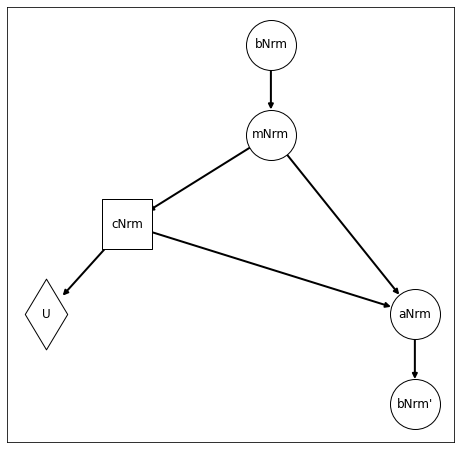

In [5]:
draw_frame_model(FrameTypeA().model)

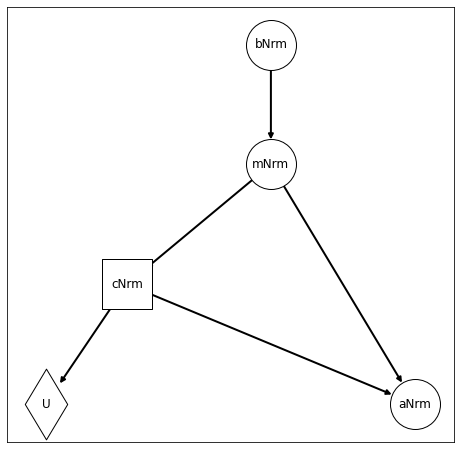

In [6]:
draw_frame_model(FrameTypeA().model.make_terminal())

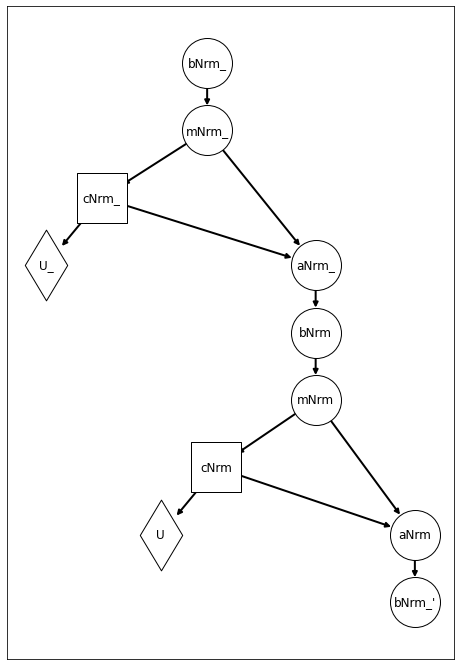

In [7]:
double_model = FrameTypeA().model.prepend(FrameTypeA().model)
draw_frame_model(double_model, figsize = (8,12))

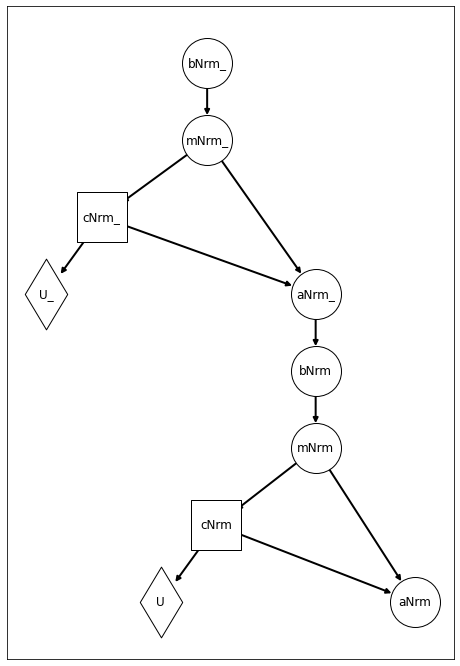

In [8]:
double_model = FrameTypeA().model.make_terminal().prepend(FrameTypeA().model)
draw_frame_model(double_model, figsize = (8,12))

## Beginning the simple solver

## Progressively more complex models

In [9]:
class FrameTypeB(FrameAgentType):
    """
    An abstract agent using Frame architecture.
    
    Introduces a stochastic shock. Idiosyncratic 
    
    """

    def __init__(self, **kwds):
        params = {}
        params.update(kwds)
        kwds = params

        # Initialize a basic consumer type
        FrameAgentType.__init__(
            self, self.model, **kwds
        )

        self.shocks = {}
        self.controls = {}
        self.state_now = {}

    # TODO: streamline this so it can draw the parameters from context
    def birth_aNrmNow(self, N):
        """
        Birth value for aNrmNow
        """
        return Lognormal(
            mu=self.aNrmInitMean,
            sigma=self.aNrmInitStd,
            seed=self.RNG.randint(0, 2 ** 31 - 1),
        ).draw(N)

    def transition_Rport(self, **context):

        Rport = (
            context["Share"] * context["Risky"]
            + (1.0 - context["Share"]) * self.parameters['Rfree']
        )
        return Rport, 

    def transition_bNrm(self, **context):
        aNrmPrev = context['aNrm']

        # This should be computed separately in its own transition
        # Using IndShock get_Rfree instead of generic.
        RfreeNow = context['Rport']

        # "Effective" interest factor on normalized assets
        ReffNow = RfreeNow / context['PermShk']
        bNrmNow = ReffNow * aNrmPrev         # Bank balances before labor income

        return bNrmNow

    def transition_mNrm(self, **context):
        mNrm = context['bNrm'] + context['TranShk']  # Market resources after income

        return mNrm


    def transition_cNrmNow(self, **context):
        """
        Transition method for cNrmNow.
        """
        cNrmNow = np.zeros(self.AgentCount) + np.nan
        ShareNow = context["Share"]

        # Loop over each period of the cycle, getting controls separately depending on "age"
        for t in range(self.T_cycle):
            these = t == self.t_cycle

            # Get controls for agents who *can* adjust their portfolio share
            those = np.logical_and(these, context['Adjust'])
            cNrmNow[those] = self.solution[t].cFuncAdj(context['mNrm'][those])

            # Get Controls for agents who *can't* adjust their portfolio share
            those = np.logical_and(
                these,
                np.logical_not(context['Adjust']))
            cNrmNow[those] = self.solution[t].cFuncFxd(
                context['mNrm'][those], ShareNow[those]
            )
        
        return cNrmNow,

    def transition_poststates(self, **context):
        """
        Calculates end-of-period assets for each consumer of this type.

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        # should this be "Now", or "Prev"?!?
        # todo: don't store on self
        self.state_now['aNrm'] = context['mNrm'] - context['cNrm']
        # Useful in some cases to precalculate asset level

        return (self.state_now['aNrm'])

    # maybe replace reference to init_portfolio to self.parameters?
    model = FrameModel([
        # todo : make an aggegrate value
        Frame(
            ('PermShk'), None,
            default = {'PermShk' : 1.0}, # maybe this is unnecessary because the shock gets sampled at t = 0
            # this is discretized before it's sampled
            transition = IndexDistribution(
                    Lognormal.from_mean_std,
                    {
                        'mean' : init_parameters['PermGroFac'],
                        'std' : init_parameters['PermShkStd']
                    }
                ).approx(
                    init_parameters['PermShkCount'], tail_N=0
                ),
        ),
        Frame(
            ('TranShk'), None,
            default = {'TranShk' : 1.0}, # maybe this is unnecessary because the shock gets sampled at t = 0
            transition = IndexDistribution(
                    MeanOneLogNormal,
                    {
                        'sigma' : init_parameters['TranShkStd']
                    }).approx(
                        init_parameters['TranShkCount'], tail_N=0
                    ),
        ),

        Frame(
            ('Rport'), ('Share', 'Risky'), 
            transition = transition_Rport
        ),
        Frame(
            ('bNrm',),
            ('aNrm', 'Rport', 'PermShk'),
            transition = transition_bNrm
        ),
        Frame(
            ('mNrm',),
            ('bNrm', 'TranShk'),
            transition = transition_mNrm
        ),
        Frame(
            ('cNrm'), ('Adjust','mNrm','Share'), 
            transition = transition_cNrmNow,
            control = True
        ),
        Frame(
            ('U'), ('cNrm','CRRA'), ## Note CRRA here is a parameter not a state var
            transition = lambda self, cNrm, CRRA : (CRRAutility(cNrm, CRRA),),
            reward = True
        ),
        Frame(
            ('aNrm'), ('mNrm', 'cNrm'),
            default = {'aNrm' : birth_aNrmNow},
            transition = lambda self, mNrm, cNrm : (mNrm - cNrm,)
        ),
    ])


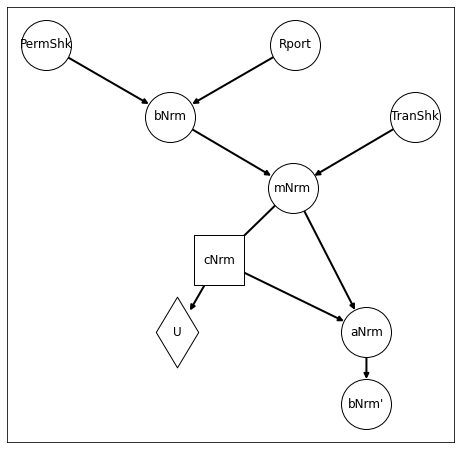

In [10]:
draw_frame_model(FrameTypeB().model)

In [11]:
class FrameTypeC(FrameAgentType):
    """
    An abstract agent using Frame architecture.
    
    Has two control variables with different stochastic shocks.
    
    """

    def __init__(self, **kwds):
        params = {}
        params.update(kwds)
        kwds = params

        # Initialize a basic consumer type
        FrameAgentType.__init__(
            self, self.model, **kwds
        )

        self.shocks = {}
        self.controls = {}
        self.state_now = {}

    # TODO: streamline this so it can draw the parameters from context
    def birth_aNrmNow(self, N):
        """
        Birth value for aNrmNow
        """
        return Lognormal(
            mu=self.aNrmInitMean,
            sigma=self.aNrmInitStd,
            seed=self.RNG.randint(0, 2 ** 31 - 1),
        ).draw(N)

    def transition_Rport(self, **context):

        Rport = (
            context["Share"] * context["Risky"]
            + (1.0 - context["Share"]) * self.parameters['Rfree']
        )
        return Rport, 

    def transition_bNrm(self, **context):
        aNrmPrev = context['aNrm']

        # This should be computed separately in its own transition
        # Using IndShock get_Rfree instead of generic.
        RfreeNow = context['Rport']

        # "Effective" interest factor on normalized assets
        ReffNow = RfreeNow / context['PermShk']
        bNrmNow = ReffNow * aNrmPrev         # Bank balances before labor income

        return bNrmNow

    def transition_mNrm(self, **context):
        mNrm = context['bNrm'] + context['TranShk']  # Market resources after income

        return mNrm

    def transition_ShareNow(self, **context):
        """
        Transition method for ShareNow.
        """
        ## Changed from HARK. See #1049. Should be added to context.
        ShareNow = self.controls['Share'].copy()

        # Loop over each period of the cycle, getting controls separately depending on "age"
        for t in range(self.T_cycle):
            these = t == self.t_cycle

            # Get controls for agents who *can* adjust their portfolio share
            those = np.logical_and(these, context['Adjust'])

            ShareNow[those] = self.solution[t].ShareFuncAdj(context['mNrm'][those])

            # Get Controls for agents who *can't* adjust their portfolio share
            those = np.logical_and(
                these,
                np.logical_not(context['Adjust']))
            ShareNow[those] = self.solution[t].ShareFuncFxd(
                context['mNrm'][those], ShareNow[those]
            )

        return ShareNow,

    def transition_cNrmNow(self, **context):
        """
        Transition method for cNrmNow.
        """
        cNrmNow = np.zeros(self.AgentCount) + np.nan
        ShareNow = context["Share"]

        # Loop over each period of the cycle, getting controls separately depending on "age"
        for t in range(self.T_cycle):
            these = t == self.t_cycle

            # Get controls for agents who *can* adjust their portfolio share
            those = np.logical_and(these, context['Adjust'])
            cNrmNow[those] = self.solution[t].cFuncAdj(context['mNrm'][those])

            # Get Controls for agents who *can't* adjust their portfolio share
            those = np.logical_and(
                these,
                np.logical_not(context['Adjust']))
            cNrmNow[those] = self.solution[t].cFuncFxd(
                context['mNrm'][those], ShareNow[those]
            )
        
        return cNrmNow,

    def transition_poststates(self, **context):
        """
        Calculates end-of-period assets for each consumer of this type.

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        # should this be "Now", or "Prev"?!?
        # todo: don't store on self
        self.state_now['aNrm'] = context['mNrm'] - context['cNrm']
        # Useful in some cases to precalculate asset level

        return (self.state_now['aNrm'])

    # maybe replace reference to init_portfolio to self.parameters?
    model = FrameModel([
        # todo : make an aggegrate value
        Frame(
            ('PermShk'), None,
            default = {'PermShk' : 1.0}, # maybe this is unnecessary because the shock gets sampled at t = 0
            # this is discretized before it's sampled
            transition = IndexDistribution(
                    Lognormal.from_mean_std,
                    {
                        'mean' : init_parameters['PermGroFac'],
                        'std' : init_parameters['PermShkStd']
                    }
                ).approx(
                    init_parameters['PermShkCount'], tail_N=0
                ),
        ),
        Frame(
            ('TranShk'), None,
            default = {'TranShk' : 1.0}, # maybe this is unnecessary because the shock gets sampled at t = 0
            transition = IndexDistribution(
                    MeanOneLogNormal,
                    {
                        'sigma' : init_parameters['TranShkStd']
                    }).approx(
                        init_parameters['TranShkCount'], tail_N=0
                    ),
        ),
        Frame( ## TODO: Handle Risky as an Aggregate value
            ('Risky'),None, 
            transition = IndexDistribution(
                Lognormal.from_mean_std,
                {
                    'mean' : init_parameters['RiskyAvg'],
                    'std' : init_parameters['RiskyStd']
                }
                # seed=self.RNG.randint(0, 2 ** 31 - 1) : TODO: Seed logic
            ).approx(
                init_parameters['RiskyCount']
            ),
            aggregate = True
        ),
        Frame(
            ('Rport'), ('Share', 'Risky'), 
            transition = transition_Rport
        ),
        Frame(
            ('bNrm',),
            ('aNrm', 'Rport', 'PermShk'),
            transition = transition_bNrm
        ),
        Frame(
            ('mNrm',),
            ('bNrm', 'TranShk'),
            transition = transition_mNrm
        ),
        Frame(
            ('Share'), ('Adjust', 'mNrm'),
            default = {'Share' : 0}, 
            transition = transition_ShareNow,
            control = True
        ),
        Frame(
            ('cNrm'), ('Adjust','mNrm','Share'), 
            transition = transition_cNrmNow,
            control = True
        ),
        Frame(
            ('U'), ('cNrm','CRRA'), ## Note CRRA here is a parameter not a state var
            transition = lambda self, cNrm, CRRA : (CRRAutility(cNrm, CRRA),),
            reward = True
        ),
        Frame(
            ('aNrm'), ('mNrm', 'cNrm'),
            default = {'aNrm' : birth_aNrmNow},
            transition = lambda self, mNrm, cNrm : (mNrm - cNrm,)
        ),
    ])


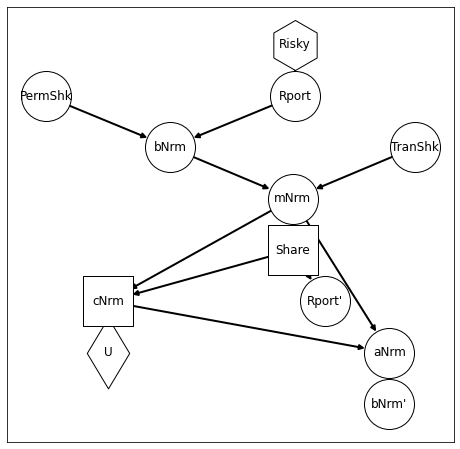

In [12]:
draw_frame_model(FrameTypeC().model)